In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load the dataset
hcho_data = pd.read_csv('preprocessed_dataset/kan_pp.csv')
hcho_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000176,Kandy Proper,2019-01-01,2019-01-02
1,0.000092,Kandy Proper,2019-01-02,2019-01-03
2,0.000092,Kandy Proper,2019-01-03,2019-01-04
3,0.000191,Kandy Proper,2019-01-04,2019-01-05
4,0.000122,Kandy Proper,2019-01-05,2019-01-06


In [24]:
# Convert 'Current Date' to datetime format
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])

In [25]:
hcho_data.set_index('Current Date', inplace=True)
hcho_data.head()

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000176,Kandy Proper,2019-01-02
2019-01-02,0.000092,Kandy Proper,2019-01-03
2019-01-03,0.000092,Kandy Proper,2019-01-04
2019-01-04,0.000191,Kandy Proper,2019-01-05
2019-01-05,0.000122,Kandy Proper,2019-01-06


In [26]:
hcho_data['Month'] = hcho_data.index.month
hcho_data['Year'] = hcho_data.index.year
hcho_data

,HCHO Reading,Location,Next Date,Month,Year
Current Date,,,,,
2019-01-01,0.000176,Kandy Proper,2019-01-02,1,2019
2019-01-02,0.000092,Kandy Proper,2019-01-03,1,2019
2019-01-03,0.000092,Kandy Proper,2019-01-04,1,2019
2019-01-04,0.000191,Kandy Proper,2019-01-05,1,2019
2019-01-05,0.000122,Kandy Proper,2019-01-06,1,2019
...,...,...,...,...,...
2023-12-27,0.000056,Kandy Proper,2023-12-28,12,2023
2023-12-28,0.000056,Kandy Proper,2023-12-29,12,2023
2023-12-29,0.000056,Kandy Proper,2023-12-30,12,2023


### ARIMA

In [30]:
# ARIMA model parameters
p = range(0, 6)
d = range(0, 5)
q = range(0, 6)
pdq = itertools.product(p, d, q)

best_aic = float('inf')
best_order = None

# Define the training and testing sets
train_size = int(len(hcho_data) * 0.6)
train_data = hcho_data.iloc[:train_size]
test_data = hcho_data.iloc[train_size:]

# Iterate over various combinations of p, d, and q to find the best ARIMA model
for order in pdq:
    try:
        model = ARIMA(train_data['HCHO Reading'], order=order)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
        print(f'ARIMA{order} - AIC: {aic:.2f}')
    except:
        continue

print(f'Best ARIMA model: ARIMA{best_order} - AIC: {best_aic:.2f}')


ARIMA(0, 0, 0) - AIC: -17907.26
ARIMA(0, 0, 1) - AIC: -18176.87
ARIMA(0, 0, 2) - AIC: -18215.04
ARIMA(0, 0, 3) - AIC: -18262.23
ARIMA(0, 0, 5) - AIC: -18272.03
ARIMA(0, 1, 0) - AIC: -17960.44
ARIMA(0, 1, 1) - AIC: -18119.84
ARIMA(0, 1, 2) - AIC: -18158.56
ARIMA(0, 1, 3) - AIC: -18165.08
ARIMA(0, 1, 4) - AIC: -18177.48
ARIMA(0, 1, 5) - AIC: -18175.94
ARIMA(0, 2, 0) - AIC: -16910.51
ARIMA(0, 2, 1) - AIC: -17736.34
ARIMA(0, 2, 2) - AIC: -17780.42
ARIMA(0, 2, 3) - AIC: -16890.83
ARIMA(0, 2, 4) - AIC: -16884.42
ARIMA(0, 2, 5) - AIC: -16887.04
ARIMA(0, 3, 0) - AIC: -15637.59
ARIMA(0, 3, 1) - AIC: -15631.45
ARIMA(0, 3, 2) - AIC: -17413.51


In [27]:
# Define the training and testing sets
train_size = int(len(hcho_data) * 0.8)
train_data = hcho_data[:train_size]
test_data = hcho_data[train_size:]

best_order = (1, 0, 5)

model = ARIMA(train_data['HCHO Reading'], order=best_order)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           HCHO Reading   No. Observations:                 1460
Model:                 ARIMA(1, 0, 5)   Log Likelihood               12181.780
Date:                Tue, 16 Apr 2024   AIC                         -24347.560
Time:                        14:00:21   BIC                         -24305.271
Sample:                    01-01-2019   HQIC                        -24331.784
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.12e-06     26.348      0.000       0.000       0.000
ar.L1          0.8362   3.54e-10   2.36e+09      0.000       0.836       0.836
ma.L1         -0.3223   1.81e-10  -1.78e+09      0.000      -0.322      -0.322
ma.L2         -0.1338   1.69e-10  -7.91e+08      0.000      -0.134      -0.134
ma.L3         -0.0137    1.3e-10  -1.06e+08      0.000      -0.014      -0.014
ma.L4         -0.0715   1.08e-10  -6.65e+08      0.000      -0.071      -0.071
ma.L5         -0.0202   7.84e-11  -2.57e+08      0.000      -0.020      -0.020
sigma2      3.307e-09   1.19e-10     27.782      0.000    3.07e-09    3.54e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               122.06
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.39
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+26. Standard errors may be unstable.
"""

### FORECASTING

In [28]:
forecast_steps = len(test_data)
forecast = results.forecast(steps=forecast_steps)

print("Forecasted values:")
forecast

Forecasted values:


2022-12-31    0.000050
2023-01-01    0.000067
2023-01-02    0.000080
2023-01-03    0.000090
2023-01-04    0.000094
                ...   
2023-12-27    0.000108
2023-12-28    0.000108
2023-12-29    0.000108
2023-12-30    0.000108
2023-12-31    0.000108
Freq: D, Name: predicted_mean, Length: 366, dtype: float64

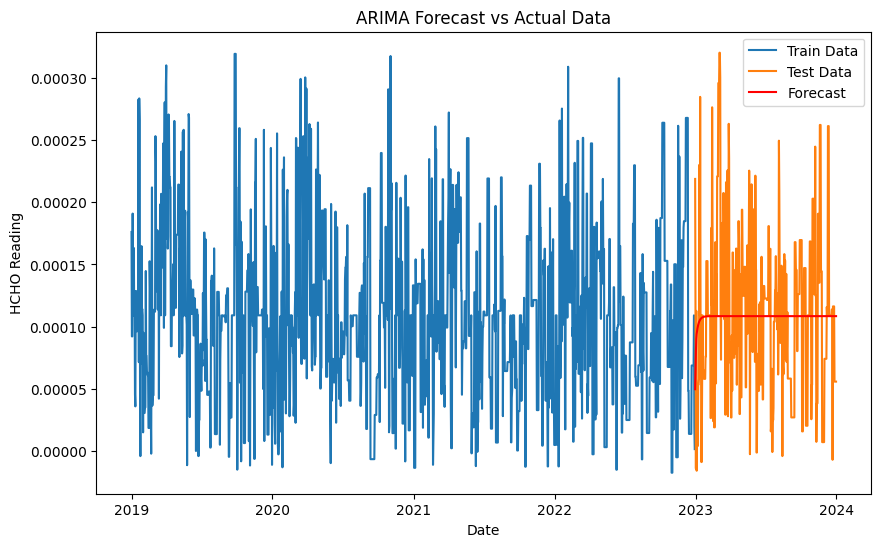

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['HCHO Reading'], label='Train Data')
plt.plot(test_data.index, test_data['HCHO Reading'], label='Test Data')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('ARIMA Forecast vs Actual Data')
plt.legend()
plt.show()

In [30]:
import plotly.graph_objects as go

fig = go.Figure()

# Adding training data to the figure
fig.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data['HCHO Reading'],
    mode='lines',
    name='Train Data',
    line=dict(width=2, color='rgba(60, 88, 128, 0.7)'), 
))

# Adding test data to the figure
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data['HCHO Reading'],
    mode='lines',
    name='Test Data',
    line=dict(width=2, color='rgba(224, 76, 95, 0.7)'), 
))

# Adding forecast data to the figure
fig.add_trace(go.Scatter(
    x=test_data.index, 
    y=forecast,
    mode='lines',
    name='Forecast',
    line=dict(width=3, color='red', dash='dash'), 
))

# Adding vertical line to indicate start of forecast
fig.add_vline(x=test_data.index[0], line_width=2, line_dash="dash", line_color="green")

# Annotations for Train and Forecast
fig.add_annotation(
    x=train_data.index[int(len(train_data) / 2)],
    y=max(train_data['HCHO Reading']),
    text="<b>Training Data</b>",
    showarrow=False,
    font_size=12,
)

fig.add_annotation(
    x=test_data.index[int(len(test_data) / 2)],
    y=max(test_data['HCHO Reading']),
    text="<b>Forecast</b>",
    showarrow=False,
    font_size=12,
)

# Updating the axes and layout
fig.update_xaxes(title="Date", showgrid=False)
fig.update_yaxes(title="HCHO Reading", showgrid=False, type="linear")

fig.update_layout(
    width=840,
    height=540,
    title="HCHO Data: Training, Test, and Forecast",
    font_color='black', 
    title_font_size=18,
    plot_bgcolor='white', 
    paper_bgcolor='white', 
    legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h"),
)

fig.show()

In [31]:
# Converting the forecast to a pandas Series and ensuring it aligns with the test data's index
forecast_series = pd.Series(forecast, index=test_data.index)

# Calculating the MAE
mae = np.mean(np.abs(forecast_series - test_data['HCHO Reading']))
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 5.2477609790245885e-05


In [32]:
print("Missing values in forecast:", forecast.isnull().sum())
print("Missing values in actual data:", test_data['HCHO Reading'].isnull().sum())

print("Length of forecast:", len(forecast))
print("Length of actual data:", len(test_data['HCHO Reading']))

print("Index of forecast:", test_data.index)
print("Index of actual data:", test_data['HCHO Reading'].index)

Missing values in forecast: 0
Missing values in actual data: 0
Length of forecast: 366
Length of actual data: 366
Index of forecast: DatetimeIndex(['2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07',
               '2023-01-08', '2023-01-09',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Current Date', length=366, freq=None)
Index of actual data: DatetimeIndex(['2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07',
               '2023-01-08', '2023-01-09',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30'

In [33]:
forecast_df = pd.DataFrame(forecast, index=test_data.index)

forecast_aligned = forecast_df.reindex(test_data.index)

mae = np.mean(np.abs(forecast_aligned.squeeze() - test_data['HCHO Reading']))
print("\nMean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 5.2477609790245885e-05


In [34]:
print("NaN values in forecast:", forecast_aligned.isnull().sum())
print("NaN values in actual data:", test_data.isnull().sum())

NaN values in forecast: predicted_mean    0
dtype: int64
NaN values in actual data: HCHO Reading    0
Location        0
Next Date       0
Month           0
Year            0
dtype: int64


In [35]:
print("Forecast data:\n", forecast_aligned)
print("\nActual data:\n", test_data)

Forecast data:
               predicted_mean
Current Date                
2022-12-31          0.000050
2023-01-01          0.000067
2023-01-02          0.000080
2023-01-03          0.000090
2023-01-04          0.000094
...                      ...
2023-12-27          0.000108
2023-12-28          0.000108
2023-12-29          0.000108
2023-12-30          0.000108
2023-12-31          0.000108

[366 rows x 1 columns]

Actual data:
               HCHO Reading      Location   Next Date  Month  Year
Current Date                                                     
2022-12-31        0.000219  Kandy Proper  2023-01-01     12  2022
2023-01-01        0.000109  Kandy Proper  2023-01-02      1  2023
2023-01-02       -0.000014  Kandy Proper  2023-01-03      1  2023
2023-01-03        0.000113  Kandy Proper  2023-01-04      1  2023
2023-01-04       -0.000016  Kandy Proper  2023-01-05      1  2023
...                    ...           ...         ...    ...   ...
2023-12-27        0.000056  Kandy Proper

In [36]:
print("NaN values in training data:", train_data.isnull().sum())

try:
    model = ARIMA(train_data['HCHO Reading'], order=best_order)
    results = model.fit()
    print("Model fitting successful.")
except Exception as e:
    print("Error during model fitting:", e)

if 'results' in locals():
    forecast_steps = len(test_data)
    forecast = results.forecast(steps=forecast_steps)
    print("\nForecast data:\n", forecast)
else:
    print("\nModel fitting failed. Cannot generate forecast.")

NaN values in training data: HCHO Reading    0
Location        0
Next Date       0
Month           0
Year            0
dtype: int64


Model fitting successful.

Forecast data:
 2022-12-31    0.000050
2023-01-01    0.000067
2023-01-02    0.000080
2023-01-03    0.000090
2023-01-04    0.000094
                ...   
2023-12-27    0.000108
2023-12-28    0.000108
2023-12-29    0.000108
2023-12-30    0.000108
2023-12-31    0.000108
Freq: D, Name: predicted_mean, Length: 366, dtype: float64


In [37]:
forecast_index = pd.date_range(start=test_data.index[0], periods=len(forecast), freq='MS')

forecast.index = forecast_index

print("Index of forecast data after conversion:\n", test_data.index)

Index of forecast data after conversion:
 DatetimeIndex(['2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07',
               '2023-01-08', '2023-01-09',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Current Date', length=366, freq=None)


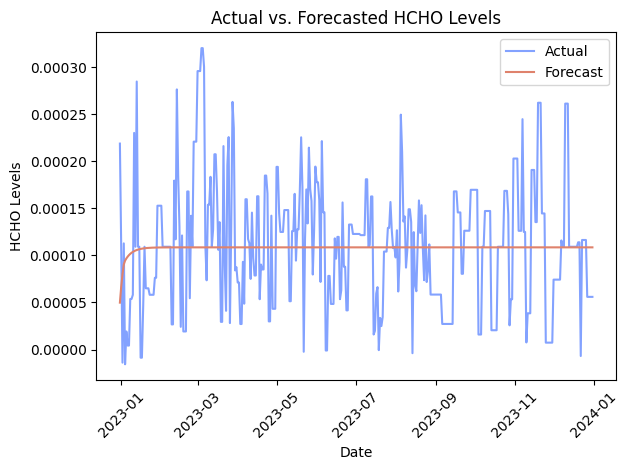

In [38]:
plt.plot(test_data.index, test_data['HCHO Reading'], color='#83A2FF', label='Actual')

plt.plot(test_data.index, forecast, color='#DF826C', label='Forecast')

plt.xlabel('Date')
plt.ylabel('HCHO Levels')
plt.title('Actual vs. Forecasted HCHO Levels')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### FUTURE FORECASTING

In [39]:
future_data = hcho_data['HCHO Reading']

model = ARIMA(future_data, order=(1, 0, 5))
fit_model = model.fit()

forecast_steps = 20
forecast = fit_model.forecast(steps=forecast_steps)
print(forecast)

2024-01-01    0.000078
2024-01-02    0.000089
2024-01-03    0.000095
2024-01-04    0.000100
2024-01-05    0.000102
2024-01-06    0.000104
2024-01-07    0.000105
2024-01-08    0.000106
2024-01-09    0.000107
2024-01-10    0.000108
2024-01-11    0.000108
2024-01-12    0.000108
2024-01-13    0.000108
2024-01-14    0.000109
2024-01-15    0.000109
2024-01-16    0.000109
2024-01-17    0.000109
2024-01-18    0.000109
2024-01-19    0.000109
2024-01-20    0.000109
Freq: D, Name: predicted_mean, dtype: float64


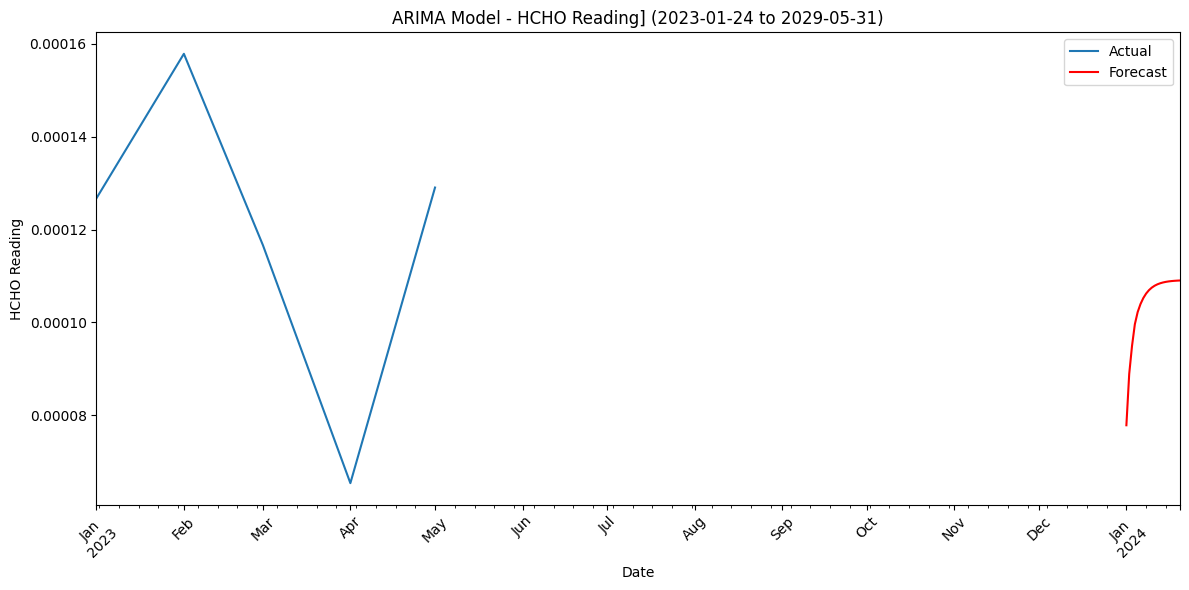

In [43]:
hcho_data = pd.DataFrame({'HCHO Reading': [0.00012672353729286647, 0.000157848076281027, 0.00011665895368421289, 0.00006540852992918962, 0.00012905545653340233]},
                      index=pd.date_range('2023-01-24', periods=5, freq='M'))

plt.figure(figsize=(12, 6))
hcho_data['HCHO Reading'].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('ARIMA Model - HCHO Reading] (2023-01-24 to 2029-05-31)')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()